In [25]:
import os
import base64
import requests
import pandas as pd
import pymysql
import pymongo
import datetime
import ssl
from neo4j import GraphDatabase

from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import ast
from collections import Counter
from wordcloud import WordCloud # https://github.com/amueller/word_cloud/issues/637

This code retrieves the top popular songs from Spotify for each year from 2000 to 2022 and saves the data to a MySQL database, a CSV file, a MongoDB collection, and a Neo4j graph. Multiple choices of databases are used for learning purposes.

The code first retrieves the access token from the Spotify API. Then, it iterates over the years from 2000 to 2022 and calls the search_popular_songs_by_year() function to get the top popular songs for each year. The results are stored in a list. Finally, the code saves the data to the four different data stores.

In [4]:
client_id = 'id'
client_secret = 'secret'

CLIENT_ID = client_id
CLIENT_SECRET = client_secret

# Function to get the access token
def get_token():
    auth_string = CLIENT_ID + ':' + CLIENT_SECRET
    auth_bytes = auth_string.encode('utf-8')
    auth_base64 = base64.b64encode(auth_bytes).decode('utf-8')

    url = 'https://accounts.spotify.com/api/token'
    headers = {
        'Authorization': 'Basic ' + auth_base64,
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    data = {'grant_type': 'client_credentials'}
    response = requests.post(url, headers=headers, data=data)

    if response.status_code == 200:
        json_result = response.json()
        token = json_result['access_token']
        return token
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

def search_popular_songs_by_year(access_token, year):
    tracks_with_audio_features = []

    headers = {
        'Authorization': 'Bearer ' + access_token
    }

    search_url = 'https://api.spotify.com/v1/search'


    params = {
        'q': f'year:{year}',
        'type': 'track',
        'limit': 50
    }

    response = requests.get(search_url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        tracks = data.get('tracks', {}).get('items', [])

        # Extract relevant data from the tracks and add them to the tracks_with_audio_features list
        for track in tracks:
            # Get the track ID for audio features
            track_id = track['id']

            # Retrieve audio features for the track
            audio_features_url = f'https://api.spotify.com/v1/audio-features/{track_id}'
            audio_features_response = requests.get(audio_features_url, headers=headers)
            audio_features_data = audio_features_response.json()

            # Check if audio features are available for this track
            if 'danceability' in audio_features_data:
                track_data = {
                    'Track Name': track['name'],
                    'Artist': ', '.join([artist['name'] for artist in track['artists']]),
                    'Duration_ms': track['duration_ms'],
                    'Popularity': track['popularity'],
                    'Release Date': track['album']['release_date'],
                    'Year': year,
                    'Danceability': audio_features_data['danceability'],
                    'Energy': audio_features_data['energy'],
                    'Tempo': audio_features_data['tempo'],
                    'Acousticness': audio_features_data['acousticness'],
                    'Loudness': audio_features_data['loudness'],
                    'Instrumentalness': audio_features_data['instrumentalness']
                }
                tracks_with_audio_features.append(track_data)
            else:
                print(f"Audio features not available for track: {track['name']}")

    else:
        print(f"Error: {response.status_code} - {response.text}")

    return tracks_with_audio_features

def parse_release_date(date_str):
    # List of possible date formats Spotify might return
    date_formats = ['%Y-%m-%d', '%Y-%m', '%Y']

    for format_str in date_formats:
        try:
            return datetime.datetime.strptime(date_str, format_str).date()
        except ValueError:
            continue

    # If no valid format is found, return None
    return None

# loading to mysql and saving as csv file

def save_to_mysql_and_csv(tracks_with_audio_features):
    connection = pymysql.connect(host='localhost', user='root', password='pass', database='spotify')
    cursor = connection.cursor()

    create_table_query = """
    CREATE TABLE IF NOT EXISTS tracks_with_features (
        id INT AUTO_INCREMENT PRIMARY KEY,
        track_name VARCHAR(255),
        artist VARCHAR(255),
        duration_ms INT,
        popularity INT,
        release_date DATE,
        year INT,
        danceability FLOAT,
        energy FLOAT,
        tempo FLOAT,
        acousticness FLOAT,
        loudness FLOAT,
        instrumentalness FLOAT
    )
    """

    cursor.execute(create_table_query)

    insert_query = """
    INSERT INTO tracks_with_features (track_name, artist, duration_ms, popularity, release_date, year,
                                        danceability, energy, tempo, acousticness, loudness, instrumentalness)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """

    for track in tracks_with_audio_features:
        release_date = parse_release_date(track['Release Date'])
        if release_date is not None:
            release_date_str = release_date.strftime('%Y-%m-%d')
        else:
            release_date_str = None

        cursor.execute(insert_query, (
            track['Track Name'],
            track['Artist'],
            track['Duration_ms'],
            track['Popularity'],
            release_date_str,
            track['Year'],
            track['Danceability'],
            track['Energy'],
            track['Tempo'],
            track['Acousticness'],
            track['Loudness'],
            track['Instrumentalness'],
        ))

    connection.commit()
    connection.close()

    # Save the data to a CSV file
    df = pd.DataFrame(tracks_with_audio_features)
    df.to_csv('raw_tracks_with_audio_features.csv', index=False)

# loading to mongoDB

uri = 'uri'
client = pymongo.MongoClient(uri, ssl_cert_reqs=ssl.CERT_NONE)


db = client['mongo_task']
collection = db['tracks']


def save_to_mongodb(data):
    try:
        for track in data:
            # Convert the release date to a string in 'YYYY-MM-DD' format
            release_date = parse_release_date(track['Release Date'])
            if release_date is not None:
                release_date_str = release_date.strftime('%Y-%m-%d')
            else:
                release_date_str = None

            document = {
                'Track Name': track['Track Name'],
                'Artist': track['Artist'],
                'Popularity': track['Popularity'],
                'Release Date': release_date_str,
                'Year': track['Year'],
                'Danceability': track['Danceability'],
                'Energy': track['Energy'],
                'Tempo': track['Tempo'],
                'Acousticness': track['Acousticness'],
                'Loudness': track['Loudness'],
                'Instrumentalness': track['Instrumentalness']
            }

            collection.insert_one(document)

        print('Data inserted into MongoDB')
    except Exception as e:
        print(f'Error: {e}')

# loading to neo4j       

uri = 'uri'
username = 'neo4j'
password = 'pass'
driver = GraphDatabase.driver(uri, auth=(username, password))

def load_data_to_neo4j(session, data):
    with session.begin_transaction() as tx:
        for track in data:
            create_track_query = (
                "CREATE (track:Track {"
                "   name: $name,"
                "   artist: $artist,"
                "   popularity: $popularity,"
                "   release_date: date($release_date),"
                "   year: $year,"
                "   danceability: $danceability,"
                "   energy: $energy,"
                "   tempo: $tempo,"
                "   acousticness: $acousticness,"
                "   loudness: $loudness,"
                "   instrumentalness: $instrumentalness"
                "})"
            )

            tx.run(create_track_query, {
                "name": track['Track Name'],
                "artist": track['Artist'],
                "popularity": track['Popularity'],
                "release_date": track['Release Date'],
                "year": track['Year'],
                "danceability": track['Danceability'],
                "energy": track['Energy'],
                "tempo": track['Tempo'],
                "acousticness": track['Acousticness'],
                "loudness": track['Loudness'],
                "instrumentalness": track['Instrumentalness']
            })


def create_same_artist_relationships(session):
    with session.begin_transaction() as tx:
        query = (
            "MATCH (t1:Track), (t2:Track)"
            "WHERE t1.artist = t2.artist AND id(t1) < id(t2)"
            "MERGE (t1)-[:SAME_ARTIST]->(t2)"
        )

        tx.run(query)


if __name__ == '__main__':
    access_token = get_token()

    if access_token:
        tracks_with_audio_features = []

        years_to_collect = range(2000, 2023)  # Change the end year as needed

        for year in years_to_collect:
            year_tracks = search_popular_songs_by_year(access_token, year)
            tracks_with_audio_features.extend(year_tracks)

        # save data to a file or process it further as needed

        save_to_mysql_and_csv(tracks_with_audio_features)
        save_to_mongodb(tracks_with_audio_features)
        with driver.session() as session:
            load_data_to_neo4j(session, tracks_with_audio_features)
            create_same_artist_relationships(session)
        driver.close()

    else:
        print('Access token retrieval failed.')

Audio features not available for track: Deep Phase Noise 1
Data inserted into MongoDB


Fetch data from MySQL, mongoDB and neo4j databases, store it in a Pandas DataFrames, and save it as a CSV files if the retrieval is successful

In [5]:
def read_data_from_mysql(host, user, password, database, table):
    try:
        connection = pymysql.connect(
            host='localhost',
            user='root',
            password='pass',
            database='spotify'
        )
        cursor = connection.cursor()

        query = f'SELECT id, track_name, artist, duration_ms, popularity, release_date, year FROM {table}'
        cursor.execute(query)

        result = cursor.fetchall()

        cursor.close()
        connection.close()

        return result

    except pymysql.Error as e:
        print(f'Error: {e}')
        return None

host = 'your_host'
user = 'your_username'
password = 'your_password'
database = 'your_database_name'
table = 'tracks_with_features'

data = read_data_from_mysql(host, user, password, database, table)

if data:
    columns = ['id', 'track_name', 'artist', 'duration_ms','popularity', 'release_date', 'year']
    df_mysql = pd.DataFrame(data, columns=columns)
    df_mysql.to_csv('raw_data_mysql.csv', index=False)

    print(df_mysql)
else:
    print('Failed to retrieve data from MySQL')

        id           track_name               artist  duration_ms  popularity  \
0        1               Sparks             Coldplay       227093          87   
1        2               Yellow             Coldplay       266773          91   
2        3  The Real Slim Shady               Eminem       284200          88   
3        4           Kryptonite         3 Doors Down       233933          82   
4        5          Ms. Jackson              Outkast       270506          83   
...    ...                  ...                  ...          ...         ...   
1144  1145              CUFF IT              Beyoncé       225388          87   
1145  1146             snowfall  Øneheart, reidenshi       124065          87   
1146  1147                   TV        Billie Eilish       281380          87   
1147  1148         JACKIE BROWN         Brent Faiyaz       169013          83   
1148  1149     SPIT IN MY FACE!             ThxSoMch       147874          86   

     release_date  year  
0

In [6]:
def read_data_from_mongodb(uri, database, collection):
    try:
        client = pymongo.MongoClient(uri, ssl_cert_reqs=ssl.CERT_NONE)

        db = client[database]
        col = db[collection]

        cursor = col.find({})
        result = list(cursor)

        client.close()

        return result

    except Exception as e:
        print(f'Error: {e}')
        return None

uri = 'uri'
database = 'mongo_task'
collection = 'tracks'

data = read_data_from_mongodb(uri, database, collection)

if data:
    df_mongo = pd.DataFrame(data)
    df_mongo.to_csv('raw_data_mongo.csv', index=True)

    print(df_mongo)
else:
    print('Failed to retrieve data from MongoDB')

                           _id                 Track Name  \
0     64f46036570e1491208c305c          Forever After All   
1     64f46037570e1491208c305d          Took Her To The O   
2     64f46037570e1491208c305e  Levitating (feat. DaBaby)   
3     64f46037570e1491208c305f          One Of Them Girls   
4     64f46037570e1491208c3060                    Secrets   
...                        ...                        ...   
2444  650496ca21e53bae8d3f51dc                    CUFF IT   
2445  650496ca21e53bae8d3f51dd                   snowfall   
2446  650496ca21e53bae8d3f51de                         TV   
2447  650496ca21e53bae8d3f51df               JACKIE BROWN   
2448  650496ca21e53bae8d3f51e0           SPIT IN MY FACE!   

                      Artist  Popularity Release Date  Year  Danceability  \
0                 Luke Combs          80   2020-10-23  2020         0.487   
1                   King Von          81   2020-03-06  2020         0.820   
2           Dua Lipa, DaBaby        

In [8]:
uri = 'uri'
username = 'neo4j'
password = 'pass'

driver = GraphDatabase.driver(uri, auth=(username, password))

def get_tracks_with_same_artist(session):
    with session.begin_transaction() as tx:
        query = """
            MATCH (t:Track)
            RETURN t.artist AS Artist, COLLECT(t.name) AS TrackNames
            ORDER BY Artist
        """

        result = tx.run(query)
        data = [record.data() for record in result]

    return data

with driver.session() as session:
    data = get_tracks_with_same_artist(session)

if data:
    df_neo4j = pd.DataFrame(data)
    df_neo4j.to_csv('raw_data_neo4j.csv', index=False)
    
    print(df_neo4j)
else:
    print('No data retrieved from Neo4j')

driver.close()

                      Artist  \
0                $uicideboy$   
1         $uicideboy$, Pouya   
2                     *NSYNC   
3                  21 Savage   
4    21 Savage, Metro Boomin   
..                       ...   
626      fun., Janelle Monáe   
627              girl in red   
628             salvia palth   
629                 t.A.T.u.   
630      Øneheart, reidenshi   

                                            TrackNames  
0    [Kill Yourself (Part III), Paris, My Flaws Bur...  
1               [Runnin' Thru the 7th with My Woadies]  
2                      [Bye Bye Bye, It's Gonna Be Me]  
3                                [ball w/o you, a lot]  
4                            [Glock In My Lap, Runnin]  
..                                                 ...  
626               [We Are Young (feat. Janelle Monáe)]  
627                       [we fell in love in october]  
628                      [i was all over her, (dream)]  
629                          [All The Things 

Reads CSV files into Spark DataFrames and checks for null and duplicate values in each column of each DataFrame

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName('NullValues').getOrCreate()

df_mysql_spark = spark.read.csv('raw_data_mysql.csv', header=True, inferSchema=True)
df_mongo_spark = spark.read.csv('raw_data_mongo.csv', header=True, inferSchema=True)
df_neo4j_spark = spark.read.csv('raw_data_neo4j.csv', header=True, inferSchema=True)

dataframes = [df_mysql_spark, df_mongo_spark, df_neo4j_spark]

def check_null_values(df, column_name):
    return df.filter(col(column_name).isNull())

for df in dataframes:
    for column_name in df.columns:
        null_values_df = check_null_values(df, column_name)
        if null_values_df.count() > 0:
            print(f'DataFrame {df}: Column {column_name} has null values:')
            null_values_df.show()

spark.stop()


DataFrame DataFrame[_c0: int, _id: string, Track Name: string, Artist: string, Popularity: int, Release Date: date, Year: int, Danceability: double, Energy: double, Tempo: double, Acousticness: double, Loudness: double, Instrumentalness: double]: Column Acousticness has null values:
+---+--------------------+--------------------+--------------------+----------+------------+----+------------+-------+-------+------------+--------+----------------+
|_c0|                 _id|          Track Name|              Artist|Popularity|Release Date|Year|Danceability| Energy|  Tempo|Acousticness|Loudness|Instrumentalness|
+---+--------------------+--------------------+--------------------+----------+------------+----+------------+-------+-------+------------+--------+----------------+
|  0|64f46036570e14912...|   Forever After All|          Luke Combs|        80|  2020-10-23|2020|       0.487|   0.65|151.964|        null|    null|            null|
|  1|64f46037570e14912...|   Took Her To The O|     

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName('ShowDuplicates').getOrCreate()
df_mysql_spark = spark.read.csv('raw_data_mysql.csv', header=True, inferSchema=True)
df_mongo_spark = spark.read.csv('raw_data_mongo.csv', header=True, inferSchema=True)
df_neo4j_spark = spark.read.csv('raw_data_neo4j.csv', header=True, inferSchema=True)

dataframes = [df_mysql_spark, df_mongo_spark, df_neo4j_spark]

def check_duplicates(df):
    grouped_df = df.groupBy(*df.columns).count()
    duplicates_df = grouped_df.filter(col('count') > 1)
    return duplicates_df

for i, df in enumerate(dataframes):
    print(f'Checking duplicates in dataframe {i + 1}:')
    duplicates_df = check_duplicates(df)
    if not duplicates_df.isEmpty():
        print('Found duplicates in dataframe:')
        duplicates_df.show()
    else:
        print('Not found duplicates in dataframe')

spark.stop()


Checking duplicates in dataframe 1:
Not found duplicates in dataframe
Checking duplicates in dataframe 2:
Not found duplicates in dataframe
Checking duplicates in dataframe 3:
Not found duplicates in dataframe


Merge two DataFrames on specified columns and drop duplicates

In [4]:
df_mysql = pd.read_csv('raw_data_mysql.csv')
df_mongo = pd.read_csv('raw_data_mongo.csv')

In [5]:
print(f'MySQL: {df_mysql.columns}\nMongoDB: {df_mongo.columns}')

MySQL: Index(['id', 'track_name', 'artist', 'duration_ms', 'popularity',
       'release_date', 'year'],
      dtype='object')
MongoDB: Index(['Unnamed: 0', '_id', 'Track Name', 'Artist', 'Popularity',
       'Release Date', 'Year', 'Danceability', 'Energy', 'Tempo',
       'Acousticness', 'Loudness', 'Instrumentalness'],
      dtype='object')


In [6]:
df_mysql = df_mysql.drop('id', axis = 1)
df_mongo = df_mongo.drop(['Unnamed: 0', '_id'], axis=1)

In [7]:
df_mongo.columns = df_mongo.columns.str.lower()
df_mongo = df_mongo.rename(columns={'track name': 'track_name', 'release date': 'release_date'})
print(df_mongo.head())

                  track_name                  artist  popularity release_date  \
0          Forever After All              Luke Combs          80   2020-10-23   
1          Took Her To The O                King Von          81   2020-03-06   
2  Levitating (feat. DaBaby)        Dua Lipa, DaBaby          86   2020-03-27   
3          One Of Them Girls               Lee Brice          77   2020-11-20   
4                    Secrets  A Boogie Wit da Hoodie          80   2020-06-19   

   year  danceability  energy    tempo  acousticness  loudness  \
0  2020         0.487   0.650  151.964           NaN       NaN   
1  2020         0.820   0.592  159.980           NaN       NaN   
2  2020         0.702   0.825  102.977           NaN       NaN   
3  2020         0.643   0.790   95.981           NaN       NaN   
4  2020         0.539   0.648   91.066           NaN       NaN   

   instrumentalness  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4     

In [8]:
df_merged_mysql_mongo = pd.merge(df_mysql, df_mongo,
                                 on=['track_name', 'artist', 'popularity', 'year', 'release_date'], how='inner')
df_merged_mysql_mongo = df_merged_mysql_mongo.drop_duplicates(
                                subset=['track_name', 'artist', 'popularity', 'year', 'release_date'])

print(df_merged_mysql_mongo.shape)

(1149, 12)


In [9]:
duplicates = df_merged_mysql_mongo[df_merged_mysql_mongo.duplicated(
    subset=['track_name', 'artist', 'popularity', 'year', 'release_date'], keep=False)]

print('Duplicates:')
print(duplicates.head())

Duplicates:
Empty DataFrame
Columns: [track_name, artist, duration_ms, popularity, release_date, year, danceability, energy, tempo, acousticness, loudness, instrumentalness]
Index: []


Convert duration from milliseconds to timedelta format, extract minutes and seconds, and add new columns with minutes and seconds in minutes:seconds format

In [10]:
df_merged_mysql_mongo['duration_time'] = pd.to_timedelta(df_merged_mysql_mongo['duration_ms'], unit='ms')

# Extract minutes and seconds
df_merged_mysql_mongo['minutes'] = df_merged_mysql_mongo['duration_time'].dt.seconds // 60
df_merged_mysql_mongo['only_seconds'] = df_merged_mysql_mongo['duration_time'].dt.seconds % 60

df_merged_mysql_mongo['duration'] = df_merged_mysql_mongo['duration_time'].dt.seconds

# New columns with minutes and seconds in minutes:seconds format
df_merged_mysql_mongo['duration_min_s'] = df_merged_mysql_mongo['minutes'].astype(str) + ':' + df_merged_mysql_mongo['only_seconds'].astype(str)

df_merged_mysql_mongo = df_merged_mysql_mongo.drop(columns=['duration_ms', 'minutes', 'only_seconds'])

print(df_merged_mysql_mongo.head(1))

  track_name    artist  popularity release_date  year  danceability  energy  \
0     Sparks  Coldplay          87   2000-07-10  2000         0.371   0.268   

     tempo  acousticness  loudness  instrumentalness          duration_time  \
0  102.617           NaN       NaN               NaN 0 days 00:03:47.093000   

   duration duration_min_s  
0       227           3:47  


Calculate summary statistics, unique values, correlation matrix, and plot a heatmap of the correlation matrix and pairplot for selected columns

Summary Statistics:
          duration   popularity  danceability       energy        tempo  \
count  1149.000000  1149.000000   1149.000000  1149.000000  1149.000000   
mean    223.392515    79.376849      0.620066     0.665171   120.700688   
std      52.653178     5.651294      0.154165     0.190698    29.478535   
min      84.000000    66.000000      0.000000     0.003420     0.000000   
25%     195.000000    75.000000      0.521000     0.543000    97.008000   
50%     220.000000    80.000000      0.623000     0.686000   119.957000   
75%     247.000000    83.000000      0.729000     0.813000   139.986000   
max     613.000000    99.000000      0.967000     0.988000   210.164000   

       acousticness    loudness  instrumentalness  
count    276.000000  276.000000        276.000000  
mean       0.218474   -6.301616          0.036977  
std        0.257776    2.968403          0.151938  
min        0.000017  -26.813000          0.000000  
25%        0.018750   -7.657250          0.0

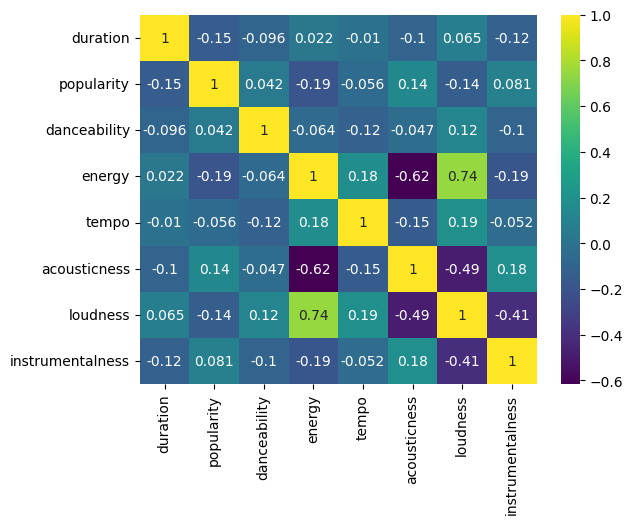

In [20]:
# Summary Statistics
summary_stats = df_merged_mysql_mongo[['duration', 'popularity', 'danceability', 'energy', 
                                       'tempo', 'acousticness', 'loudness', 'instrumentalness']].describe()

# Unique Values
unique_track_names = df_merged_mysql_mongo['track_name'].nunique()
unique_artists = df_merged_mysql_mongo['artist'].nunique()

# Correlation
correlation_matrix = df_merged_mysql_mongo[['duration', 'popularity', 'danceability', 'energy',
                                            'tempo', 'acousticness', 'loudness', 'instrumentalness']].corr()

print('Summary Statistics:')
print(summary_stats)
print('\nUnique Track Names:', unique_track_names)
print('Unique Artists:', unique_artists)

sns.heatmap(df_merged_mysql_mongo[['duration', 'popularity', 'danceability', 'energy', 'tempo', 'acousticness',
                                   'loudness', 'instrumentalness']].corr(numeric_only=True), annot=True, cmap='viridis')
plt.show()

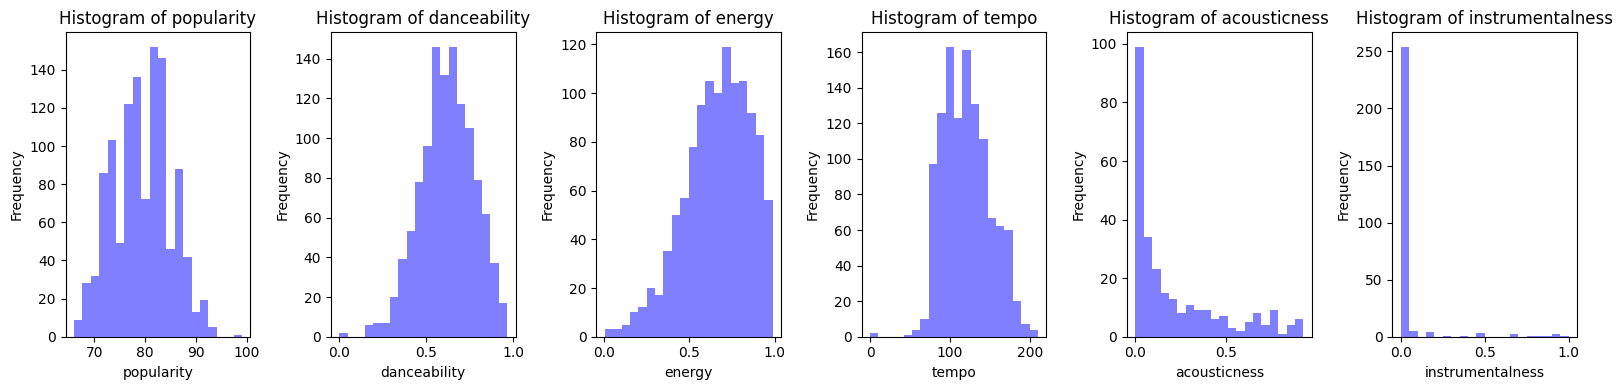

In [32]:
columns_to_plot = ['popularity', 'danceability', 'energy', 'tempo', 'acousticness', 'instrumentalness']

# Create subplots for histograms
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(16, 4))

for i, column in enumerate(columns_to_plot):
    axes[i].hist(df_merged_mysql_mongo[column], bins=20, alpha=0.5, color='blue')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Data Overview
* Number of records: 1149
* Unique Track Names: 1128
* Unique Artists: 631
* Mean duration: 223.39 seconds
#### Correlation Analysis
* There is a negative correlation between duration and popularity (-0.15). This suggests that shorter tracks tend to be more popular.
* Energy and loudness have a strong positive correlation (0.74), indicating that energetic tracks are typically louder.
* There is a negative correlation between energy and acousticness (-0.62), implying that energetic songs are less likely to be acoustic.

#### Key Findings and Insights
* Shorter tracks tend to be more popular, which could be useful for marketing and playlist curation.
* Energetic songs tend to have higher loudness and are less likely to be acoustic. This can guide music production decisions.
#### Recommendations
* Consider promoting shorter tracks to potentially increase popularity.
* Focus on producing energetic songs, as they tend to perform well.

***

Find and print the top 1% most popular, energetic, and least energetic tracks from the dataset

In [33]:
percentile_99 = df_merged_mysql_mongo['popularity'].quantile(0.99)
top_1_percent_popular_tracks = df_merged_mysql_mongo[df_merged_mysql_mongo['popularity'] >= percentile_99]
top_1_percent_popular_tracks = top_1_percent_popular_tracks[[ 'artist', 'track_name', 'popularity', 'year']]
print('\n1% most popular tracks:')
print(top_1_percent_popular_tracks.sort_values(by='popularity', ascending=False))


1% most popular tracks:
                                              artist  \
1678                                    Taylor Swift   
1150                                  Arctic Monkeys   
1503  White Noise Baby Sleep, White Noise for Babies   
1763                                    Taylor Swift   
2023                                    Taylor Swift   
2029             Metro Boomin, The Weeknd, 21 Savage   
1419                           The Weeknd, Daft Punk   
1502                  Tyler, The Creator, Kali Uchis   
2020                                             SZA   
2050                                     OneRepublic   
2061                                    Harry Styles   
2088                        David Guetta, Bebe Rexha   

                                     track_name  popularity  year  
1678                               Cruel Summer          99  2019  
1150                           I Wanna Be Yours          94  2013  
1503  Clean White Noise - Loopable with no

In [21]:
percentile_99 = df_merged_mysql_mongo['energy'].quantile(0.99)
top_1_percent_energy_tracks = df_merged_mysql_mongo[df_merged_mysql_mongo['energy'] >= percentile_99]
top_1_percent_energy_tracks = top_1_percent_energy_tracks[[ 'artist', 'track_name', 'energy', 'year']]
print('\n1% most energetic tracks:')
print(top_1_percent_energy_tracks.sort_values(by='energy', ascending=False))


1% most energetic tracks:
                        artist                track_name  energy  year
356                  Green Day            American Idiot   0.988  2004
536                The Killers       When You Were Young   0.988  2006
121          The White Stripes  Fell In Love With a Girl   0.982  2001
351                   Slipknot                   Duality   0.982  2004
482           System Of A Down                  B.Y.O.B.   0.981  2005
276                Linkin Park                     Faint   0.978  2003
583               Rise Against     Prayer Of The Refugee   0.977  2006
1915                       ame         raining for hours   0.976  2021
251                    Outkast                   Hey Ya!   0.974  2003
384                   Slipknot           Before I Forget   0.974  2004
235      Red Hot Chili Peppers                By the Way   0.970  2002
353                The Killers          Somebody Told Me   0.970  2004
504                   Mudvayne                    

In [22]:
percentile_01 = df_merged_mysql_mongo['energy'].quantile(0.01)
bottom_top_1_percent_energy_tracks = df_merged_mysql_mongo[df_merged_mysql_mongo['energy'] <= percentile_01]
bottom_top_1_percent_energy_tracks = bottom_top_1_percent_energy_tracks[[ 'artist', 'track_name', 'energy', 'year']]
print('\n1% least energetic tracks:')
print(bottom_top_1_percent_energy_tracks.sort_values(by='energy', ascending=True))


1% least energetic tracks:
                                              artist  \
1503  White Noise Baby Sleep, White Noise for Babies   
1778     Dream Supplier, Baby Sleeps, Granular Noise   
158                                       Aphex Twin   
863                                         Bon Iver   
2126                             Øneheart, reidenshi   
1487                                     Frank Ocean   
1749                                   Billie Eilish   
1694                                    Liana Flores   
1686                                     Mac DeMarco   
1993                  Laufey, Philharmonia Orchestra   
1740                                      Zach Bryan   
162                            Israel Kamakawiwo'ole   

                                     track_name   energy  year  
1503  Clean White Noise - Loopable with no fade  0.00342  2017  
1778    Clean Baby Sleep White Noise (Loopable)  0.00832  2020  
158                                       QKThr 

#### 1% Most Popular Tracks:
* These tracks are from a diverse range of artists, including Taylor Swift, Arctic Monkeys, and The Weeknd, reflecting the popularity of various genres.
#### 1% Most Energetic Tracks:
* Energetic tracks are characterized by high energy levels, with artists like Green Day, The Killers, and Slipknot standing out.
* These tracks are primarily from the mid-2000s, suggesting that this period was rich in energetic music.
#### 1% Least Energetic Tracks:
*The least energetic tracks have very low energy levels and are often instrumental or soothing in nature.
* Some of these tracks are designed for relaxation or sleep, as indicated by titles like "Clean White Noise" and "Beach Baby."
* These tracks tend to be more recent, with some from 2020 and 2022.

#### Recommendations:
* Leveraging the popularity of the 1% most popular tracks in marketing campaigns or playlists can attract a wide audience.
* Exploring energetic tracks from the mid-2000s for nostalgic or high-energy playlists could engage listeners.
* For relaxation or sleep-focused content, the least energetic tracks from recent years may be suitable.

***

Calculate the mean and standard deviation of song duration and energy, and plot the distribution of songs in each category

In [34]:
mean_duration = df_merged_mysql_mongo['duration'].mean()
std_duration = df_merged_mysql_mongo['duration'].std()

df = df_merged_mysql_mongo
# Define a function to categorize song duration
def categorize_duration(duration):
    if duration < (mean_duration - std_duration):
        return 'short'
    elif duration < (mean_duration + std_duration):
        return 'medium'
    else:
        return 'long'

df['duration_category'] = df['duration'].apply(categorize_duration)

mean_energy = df_merged_mysql_mongo['energy'].mean()
std_energy = df_merged_mysql_mongo['energy'].std()

# Define a function to categorize tempo
def categorize_energy(energy):
    if energy < (mean_energy - std_energy):
        return 'low'
    elif energy < (mean_energy + std_energy):
        return 'moderate'
    else:
        return 'high'

df['energy_category'] = df['energy'].apply(categorize_energy)

print(f'Mean Duration: {mean_duration.round(3)}')
print(f'Standard Deviation Duration: {std_duration.round(3)}')
print(f'Mean Energy: {mean_energy.round(3)}')
print(f'Standard Deviation Energy: {std_energy.round(3)}')

# Define a custom color scale for the duration_category graph
color_scale = ['#0000FF', '#00FF00', '#FF0000']
category_orders_duration = {'duration_category': ['short', 'medium', 'long']}
category_orders_energy = {'energy_category': ['low', 'moderate', 'high']}

duration_category_counts = df['duration_category'].value_counts().reset_index()
duration_category_counts.columns = ['duration_category', 'track_count']

duration_category_fig = px.bar(duration_category_counts, x='duration_category', y='track_count',
                             title='Distribution of Songs by Duration Category',
                             labels={'duration_category': 'Duration Category'},
                             hover_data={'track_count': True},
                             color='duration_category',
                             category_orders=category_orders_duration,
                             color_discrete_sequence=color_scale)

legend_labels = {
    'short': 'Short: < (mean - std)',
    'medium': 'Medium: (mean ± std)',
    'long': 'Long > (mean + std)'
}

legend_annotations = [dict(x=1.00, y=1 - 0.1 * i, xref='paper', yref='paper',
                           text=f'{legend_labels[label]}', showarrow=False)
                      for i, label in enumerate(category_orders_duration['duration_category'])]
duration_category_fig.update_layout(annotations=legend_annotations)
duration_category_fig.show()

html_file = 'duration_category_fig.html'

if not os.path.exists(html_file):
    pio.write_html(duration_category_fig, file=html_file)
    print(f'HTML file "{html_file}" has been saved.')
else:
    print(f'HTML file "{html_file}" already exists.')

# Calculate the track count for each energy category
energy_category_counts = df['energy_category'].value_counts().reset_index()
energy_category_counts.columns = ['energy_category', 'track_count']


energy_category_fig = px.bar(energy_category_counts, x='energy_category', y='track_count',
                             title='Distribution of Songs by Energy Category',
                             labels={'energy_category': 'Energy Category'},
                             hover_data={'track_count': True},
                             color='energy_category',
                             category_orders=category_orders_energy,
                             color_discrete_sequence=color_scale)

legend_labels = {
    'low': 'Low: < (mean - std)',
    'moderate': 'Medium: (mean ± std)',
    'high': 'High: > (mean + std)'
}

legend_annotations = [dict(x=1.00, y=1 - 0.1 * i, xref='paper', yref='paper',
                           text=f'{legend_labels[label]}', showarrow=False)
                      for i, label in enumerate(category_orders_energy['energy_category'])]
energy_category_fig.update_layout(annotations=legend_annotations)
energy_category_fig.show()

html_file = 'energy_category_fig.html'

if not os.path.exists(html_file):
    pio.write_html(energy_category_fig, file=html_file)
    print(f'HTML file "{html_file}" has been saved.')
else:
    print(f'HTML file "{html_file}" already exists.')

Mean Duration: 223.393
Standard Deviation Duration: 52.653
Mean Energy: 0.665
Standard Deviation Energy: 0.191


HTML file "duration_category_fig.html" has been saved.


HTML file "energy_category_fig.html" has been saved.


Fit a linear regression model to the relationship between song duration and popularity, and plot the results with correlation coefficient

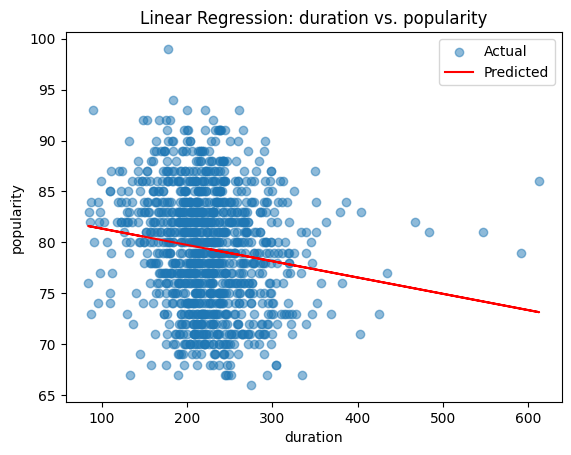

Intercept: 82.95087021819423
Coefficient: -0.01599883854753878
Correlation: -0.14906136899177336


In [38]:
model = LinearRegression()

X = df_merged_mysql_mongo[['duration']]
y = df_merged_mysql_mongo['popularity']
model.fit(X, y)

predictions = model.predict(X)

plt.scatter(X, y, label='Actual', alpha=0.5)
plt.plot(X, predictions, color='red', label='Predicted')
plt.xlabel('duration')
plt.ylabel('popularity')
plt.title('Linear Regression: duration vs. popularity')
plt.legend()
plt.show()

print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_[0]}')

correlation = df_merged_mysql_mongo['duration'].corr(df_merged_mysql_mongo['popularity'])
print(f'Correlation: {correlation}')

Fit a linear regression model to the relationship between song energy and popularity, and plot the results with correlation coefficient

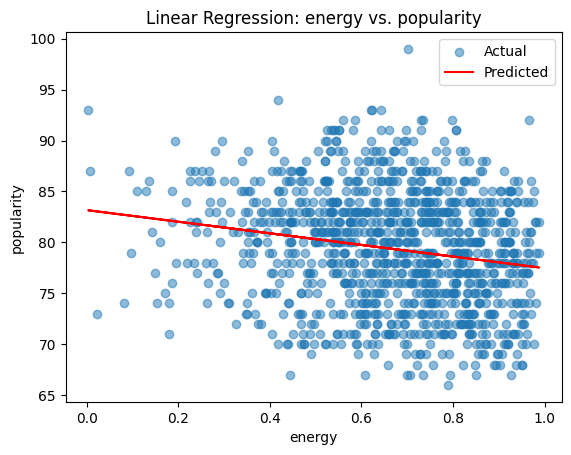

Intercept: 83.16976854356938
Coefficient: -5.702171030535692
Correlation: -0.1924144288072832


In [39]:
model = LinearRegression()

X = df_merged_mysql_mongo[['energy']]
y = df_merged_mysql_mongo['popularity']
model.fit(X, y)

predictions = model.predict(X)

plt.scatter(X, y, label='Actual', alpha=0.5)
plt.plot(X, predictions, color='red', label='Predicted')
plt.xlabel('energy')
plt.ylabel('popularity')
plt.title('Linear Regression: energy vs. popularity')
plt.legend()
plt.show()

print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_[0]}')

correlation = df_merged_mysql_mongo['energy'].corr(df_merged_mysql_mongo['popularity'])
print(f'Correlation: {correlation}')

Fit a linear regression model to the relationship between song energy and loudness, and plot the results with correlation coefficient

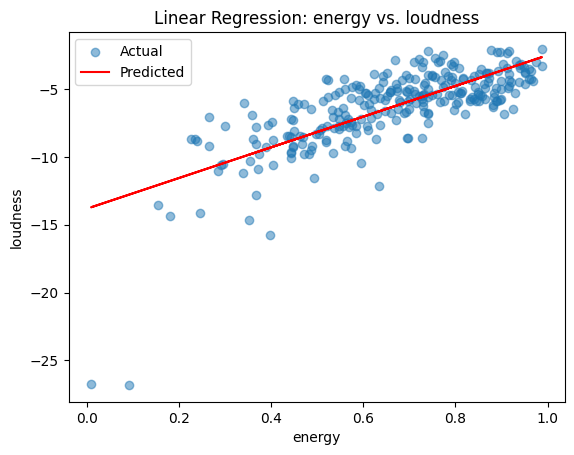

Intercept: -13.811360689463474
Coefficient: 11.301585590364386
Correlation: 0.7415752738956572


In [42]:
model = LinearRegression()

df_cleaned = df_merged_mysql_mongo.dropna(subset=['loudness'])

model = LinearRegression()
X = df_cleaned[['energy']]
y = df_cleaned['loudness']
model.fit(X, y)

predictions = model.predict(X)

plt.scatter(X, y, label='Actual', alpha=0.5)
plt.plot(X, predictions, color='red', label='Predicted')
plt.xlabel('energy')
plt.ylabel('loudness')
plt.title('Linear Regression: energy vs. loudness')
plt.legend()
plt.show()

print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_[0]}')

correlation = df_cleaned['energy'].corr(df_cleaned['loudness'])
print(f'Correlation: {correlation}')

Fit a linear regression model to the relationship between song year and popularity, and plot the results with correlation coefficient

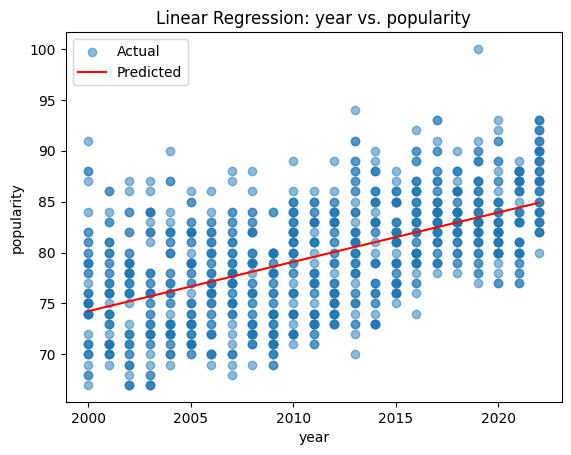

Intercept: -894.7080926664036
Coefficient: 0.4844748347573185
Correlation: 0.5675344947603814


In [25]:
model = LinearRegression()

X = df_merged_mysql_mongo[['year']]
y = df_merged_mysql_mongo['popularity']
model.fit(X, y)

predictions = model.predict(X)

plt.scatter(X, y, label='Actual', alpha=0.5)
plt.plot(X, predictions, color='red', label='Predicted')
plt.xlabel('year')
plt.ylabel('popularity')
plt.title('Linear Regression: year vs. popularity')
plt.legend()
plt.show()

print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_[0]}')

correlation = df_merged_mysql_mongo['year'].corr(df_merged_mysql_mongo['popularity'])
print(f'Correlation: {correlation}')

#### Main Insights:
* Duration vs. Popularity: there is a weak negative correlation (-0.15) between song duration and popularity. Longer songs tend to have slightly lower popularity scores. The linear regression model suggests that, on average, for every one-second increase in song duration, popularity decreases by approximately 0.016 point.
* Energy vs. Popularity: there is a moderate negative correlation (-0.19) between song energy and popularity. Energetic songs are generally less popular.
* Energy vs. Loudness: there is a strong positive correlation (0.74) between song energy and loudness. Energetic songs tend to be louder.
* Year vs. Popularity: there is a moderate positive correlation (0.57) between the year of a song's release and its popularity. More recent songs tend to be more popular.

### Recommendations:
* Playlist Curation: Curate playlists with a mix of song durations to cater to different listening contexts. For example, longer songs may be suitable for relaxation playlists, while shorter ones could be included in workout playlists.
* Diverse Energy Levels: Create playlists that balance energetic and less energetic songs to accommodate a wide range of moods and activities. This approach can enhance listener engagement.
* Stay Current: Keep an eye on recent music releases, as they are more likely to connect with the audience. Incorporate newer songs into playlists to stay relevant.
***

Read data from Neo4j, convert lists to actual lists, and calculate track counts for each artist, then sort by track count

In [35]:
df_neo4j = pd.read_csv('raw_data_neo4j.csv')

In [36]:
print(f'Neo4j: {df_neo4j.columns}')

Neo4j: Index(['Artist', 'TrackNames'], dtype='object')


In [37]:
df_neo4j = df_neo4j.rename(columns={'TrackNames': 'track_names', 'Artist': 'artist'})
print(df_neo4j.columns, df_neo4j.head())

Index(['artist', 'track_names'], dtype='object')                     artist                                        track_names
0              $uicideboy$  ['Kill Yourself (Part III)', 'Paris', 'My Flaw...
1       $uicideboy$, Pouya           ["Runnin' Thru the 7th with My Woadies"]
2                   *NSYNC                ['Bye Bye Bye', "It's Gonna Be Me"]
3                21 Savage                          ['ball w/o you', 'a lot']
4  21 Savage, Metro Boomin                      ['Glock In My Lap', 'Runnin']


In [38]:
# Convert the string representation of lists to actual lists
df_neo4j['track_names'] = df_neo4j['track_names'].apply(lambda x: ast.literal_eval(x))

In [39]:
artist_track_counts = df_neo4j.explode('track_names').groupby('artist')['track_names'].count().reset_index()

# Add a new 'track_count' column to the original DataFrame
df_neo4j['track_count'] = artist_track_counts['track_names']

print(df_neo4j.sort_values(by='track_count', ascending=False))

                         artist  \
527                Taylor Swift   
130                       Drake   
552                  The Weeknd   
270                  Kanye West   
334                 Linkin Park   
..                          ...   
233       JUVENILE, Soulja Slim   
232  JAY-Z, Rihanna, Kanye West   
231          JAY-Z, Linkin Park   
230           JAY-Z, Kanye West   
630         Øneheart, reidenshi   

                                           track_names  track_count  
527  [Our Song, Picture To Burn, Should've Said No,...           44  
130  [Best I Ever Had, Over, Headlines, Marvins Roo...           14  
552  [The Morning - Original, The Hills, Can't Feel...           13  
270  [Through The Wire, Jesus Walks, I Wonder, Stro...           13  
334  [In the End, One Step Closer, Crawling, Paperc...           12  
..                                                 ...          ...  
233                                      [Slow Motion]            1  
232                

In [40]:
# Filter rows where the artist is 'Taylor Swift'
taylor_swift_tracks = df_neo4j[df_neo4j['artist'] == 'Taylor Swift']['track_names']

for track_name in taylor_swift_tracks:
    print(len(track_name), track_name)

44 ['Our Song', 'Picture To Burn', "Should've Said No", 'Teardrops On My Guitar - Radio Single Remix', 'Tim McGraw', 'You Belong With Me', 'Love Story', 'Enchanted', 'Blank Space', 'Style', 'Shake It Off', 'New Romantics', 'Wildest Dreams', 'Bad Blood', 'Wonderland', 'Don’t Blame Me', 'Getaway Car', 'Delicate', 'Look What You Made Me Do', '...Ready For It?', 'I Did Something Bad', 'Cruel Summer', 'Lover', 'The Man', 'Paper Rings', 'All Of The Girls You Loved Before', 'Miss Americana & The Heartbreak Prince', 'You Need To Calm Down', 'The Archer', 'august', 'cardigan', 'champagne problems', 'the 1', 'my tears ricochet', "All Too Well (10 Minute Version) (Taylor's Version) (From The Vault)", "Wildest Dreams (Taylor's Version)", 'You Belong With Me (Taylor’s Version)', 'Love Story (Taylor’s Version)', 'right where you left me - bonus track', 'Fearless (Taylor’s Version)', 'The Way I Loved You (Taylor’s Version)', 'Anti-Hero', 'Karma', 'Lavender Haze']


In [42]:
# Filter artists with more than 1 track_count
filtered_df = df_neo4j[df_neo4j['track_count'] > 1]

# Create a Histogram
histogram_fig = go.Figure(data=[
    go.Histogram(
        x=filtered_df['track_count'],
        nbinsx=100,
        marker_color='blue',)])

histogram_fig.update_layout(
    title='Distribution of Artists by Track Count (more than 1 Track)',
    xaxis=dict(title='Track Count Range'),
    yaxis=dict(title='Number of Artists'),
    showlegend=False,
    bargap=0.1)

histogram_fig.show()

html_file = 'artists_by_tracks.html'

if not os.path.exists(html_file):
    pio.write_html(histogram_fig, file=html_file)
    print(f'HTML file "{html_file}" has been saved.')
else:
    print(f'HTML file "{html_file}" already exists.')

HTML file "artists_by_tracks.html" has been saved.


In [44]:
# Clean the artist names to remove special characters
df_neo4j['cleaned_artist'] = df_neo4j['artist'].str.replace('[$]', 'S', regex=True)

# Filter artists with more than 6 track_count
df_filtered_5 = df_neo4j[df_neo4j['track_count'] > 5]

fig = px.bar(df_filtered_5, x='cleaned_artist', y='track_count',
             labels={'cleaned_artist': 'Artist', 'track_count': 'Track Count'},
             title='Track Counts by Artist (more than 5 Track)')
fig.update_xaxes(categoryorder='total descending')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

html_file = 'track_counts_by_top_artist.html'

if not os.path.exists(html_file):
    pio.write_html(fig, file=html_file)
    print(f'HTML file "{html_file}" has been saved.')
else:
    print(f'HTML file "{html_file}" already exists.')

HTML file "track_counts_by_top_artist.html" has been saved.


In [45]:
fig = px.treemap(
    df_filtered_5,
    path=['cleaned_artist'],
    values='track_count',
    custom_data=['cleaned_artist', 'track_count'])


fig.update_traces(
    hovertemplate='<b>Artist:</b> %{customdata[0]}<br><b>Track Count:</b> %{customdata[1]}<br>')

fig.update_layout(
    title='Treemap of Track Counts by Artist',
    margin=dict(l=0, r=0, b=0, t=30))

fig.show()

html_file = 'treemap_tracks.html'

if not os.path.exists(html_file):
    pio.write_html(fig, file=html_file)
    print(f'HTML file "{html_file}" has been saved.')
else:
    print(f'HTML file "{html_file}" already exists.')

HTML file "treemap_tracks.html" has been saved.


The: 77
(: 67
You: 58
Me: 44
I: 43
My: 41
the: 38
Love: 32
It: 23
In: 22
A: 22
You,: 19
a: 18
to: 16
Of: 16
of: 16
Me,: 16
All: 15
Like: 14
On: 14


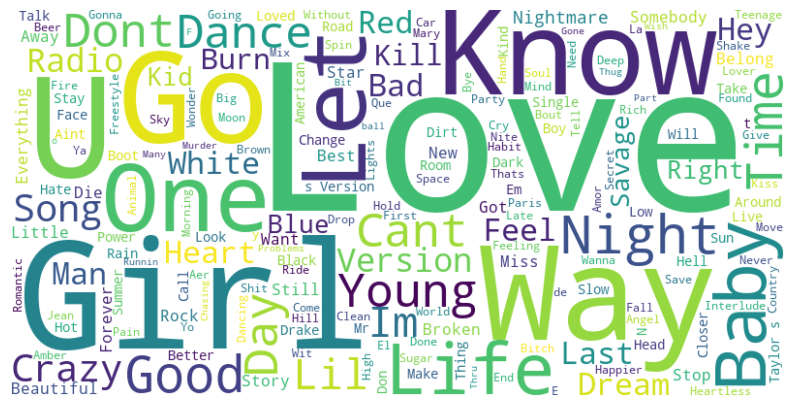

In [19]:
# Function to generate and display a word cloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Concatenate all track_names into a single string
all_track_names = ' '.join(df_neo4j['track_names'].astype(str))
words_to_remove = ['feat', 'remix', 'ft', 'ft.', "'", '.', '-', '&', '[', ']', '(with']
for word in words_to_remove:
    all_track_names = all_track_names.replace(word, "")


word_counts = Counter(all_track_names.split())
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
top_20_words = dict(list(sorted_word_counts.items())[:20])
for word, count in top_20_words.items():
    print(f'{word}: {count}')

# Generate and display the word cloud
generate_wordcloud(all_track_names)

#### Top Artists and Their Popular Tracks:

* The analysis identifies top artists, such as Taylor Swift, Drake, and The Weeknd, based on the number of popular tracks they have in the dataset. For example, Taylor Swift has 44 popular tracks in the dataset, showcasing her strong presence in popular music.

#### Word Frequency in Track Names:

* The analysis reveals the frequency of specific words in track names, indicating which words are commonly used in song titles.
* Words like "Love," "Girl," and "You" are among the most frequently used words in track names.

#### Recommendations:

* Artist Collaboration: Explore collaboration opportunities with the top artists identified in the analysis. Collaborative tracks can attract the fanbases of both artists, potentially increasing listenership.

* Playlist and Marketing Strategies: Incorporate popular words from track names into playlist titles, descriptions, and marketing materials. This can help create a connection between the playlist and the themes found in popular songs.